In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt

from numpy.random import randn, rand
from scipy.stats import multivariate_normal
from scipy.linalg import block_diag


# PF and EKF implementation
## Problem setup
We are given a setup, shown in the figure, to estimate the 3D position of an object's center. The object is stationary, and there are also two fixed monocular cameras in the room. A previously developed object detection algorithm can provide the object's center in the 2D image coordinates. However, the depth is not observable by a single RGB image. Therefore, our goal is to combine measurements from two cameras to estimate the object's 3D position in the frame of camera 1. The relative pose (orientation and translation) between the two cameras is accurately known and given. 

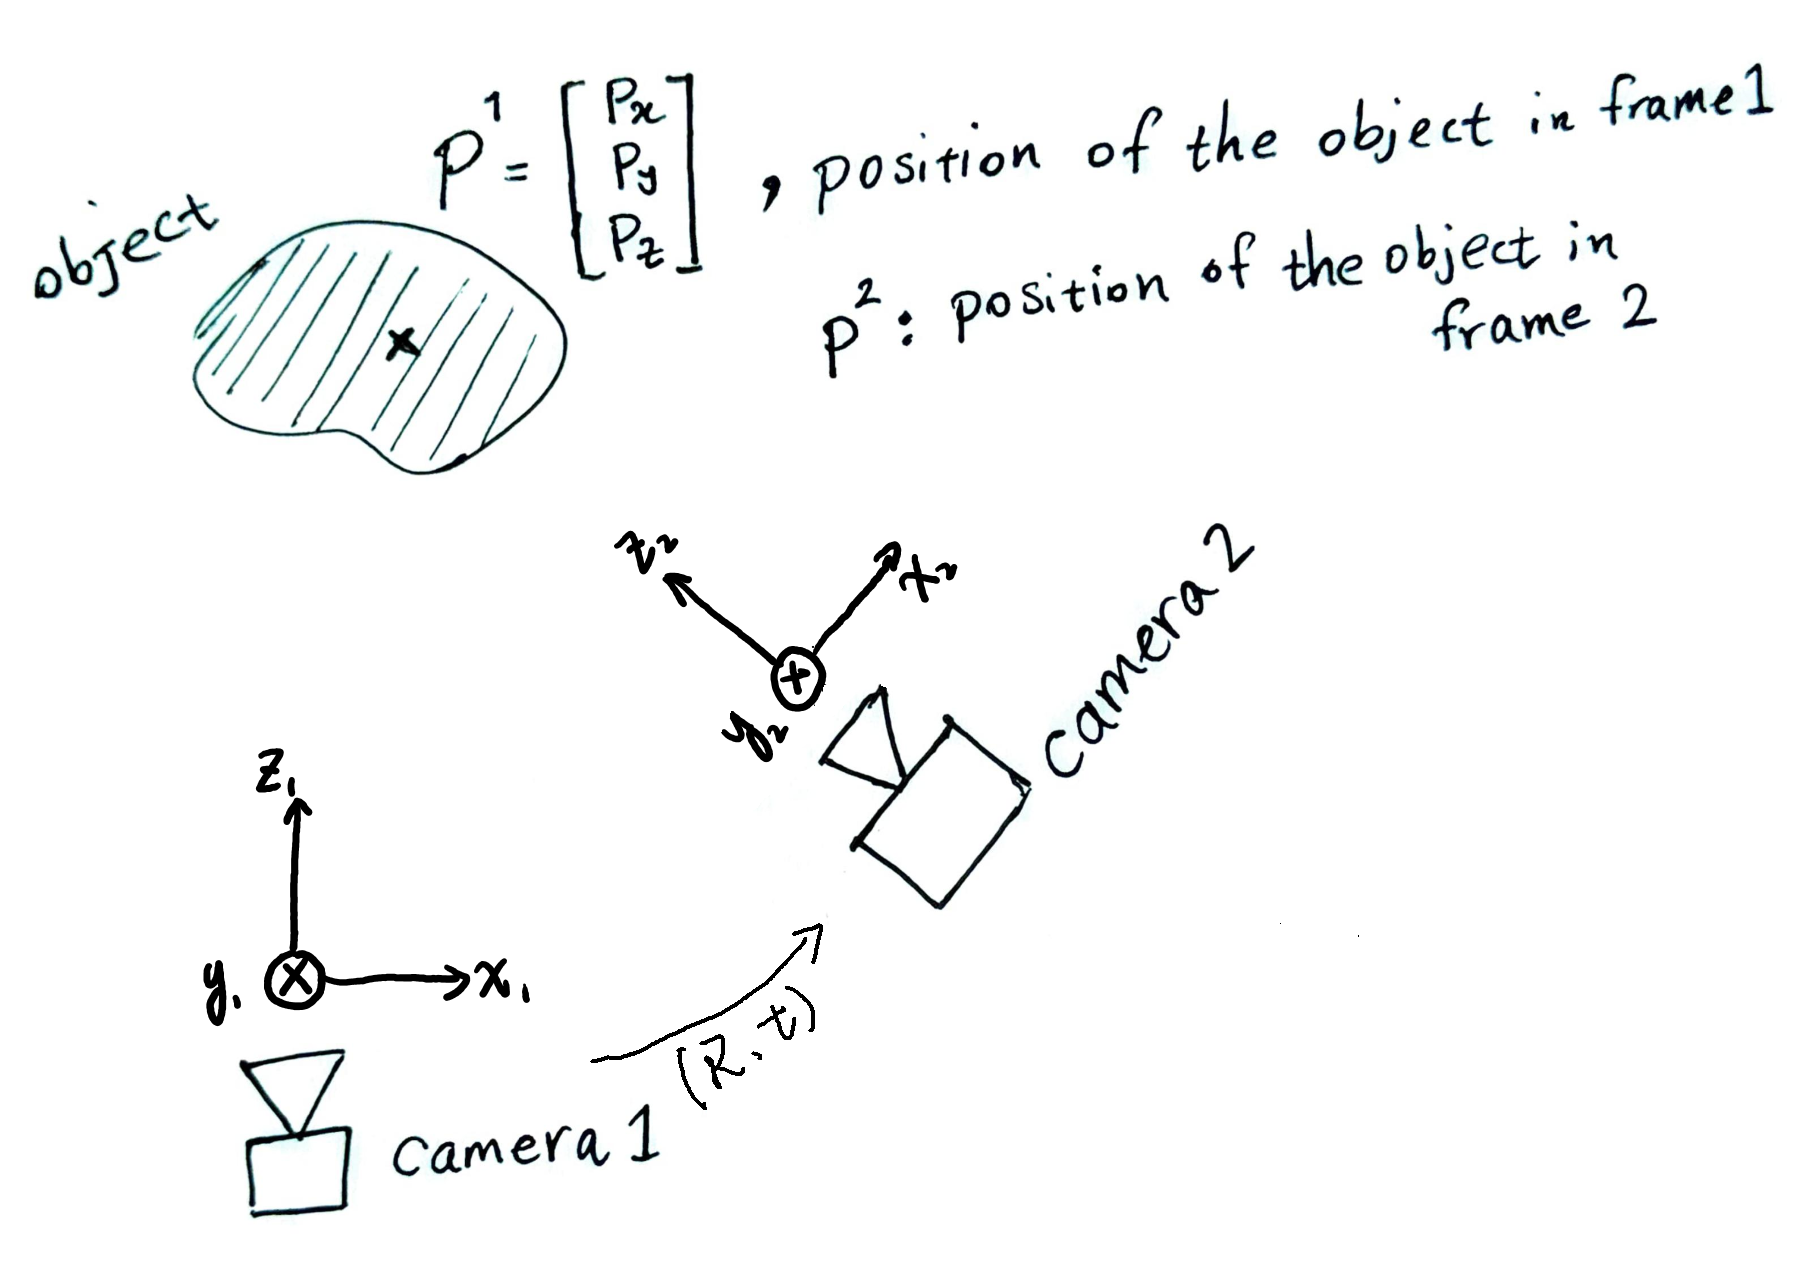


# Pinhole model
### World Frame -> Camera frame -> Pixel frame
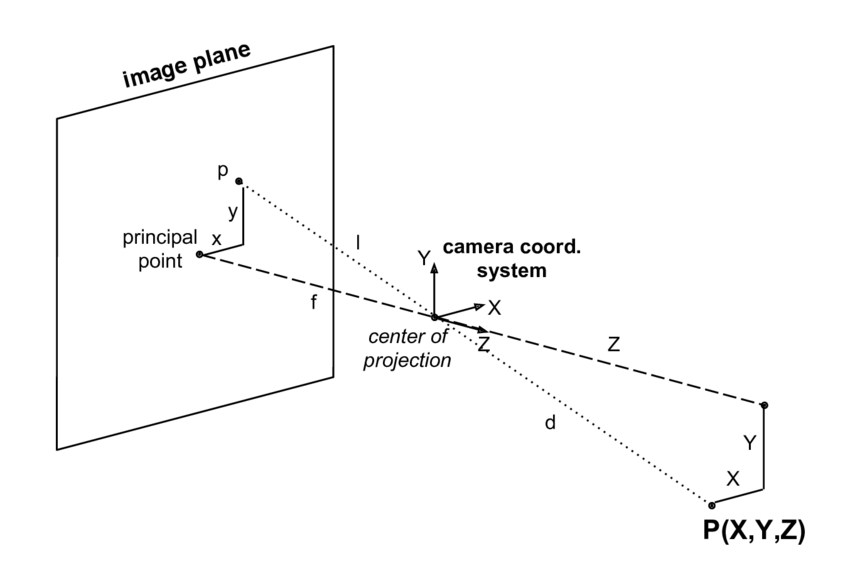
https://www.researchgate.net/figure/Pinhole-camera-model-with-a-point-PX-Y-Z-according-to-the-camera-coordinate-system_fig2_326717734

# Measurement Model
From an elementary computer vision knowledge, we know that a monocular pinhole camera model takes the following form
\begin{equation*}
    \begin{bmatrix}
    u \\ 
    v
    \end{bmatrix} = \begin{bmatrix} 
    f_x & 0 \\
    0 & f_y
    \end{bmatrix} \cdot  \frac{1}{p_z} \cdot \begin{bmatrix}
    p_x \\ p_y
    \end{bmatrix} + \begin{bmatrix}
    c_x \\ 
    c_y
    \end{bmatrix} = K_f \pi(p) + c,
\end{equation*}
where $K_f = \begin{bmatrix} 
    f_x & 0 \\
    0 & f_y
    \end{bmatrix}$ is called intrinsic camera matrix, $\begin{bmatrix}
    c_x \\ 
    c_y
    \end{bmatrix}$ is the coordinates of the optical center of the image, and $\pi(\cdot)$ is the projection function (it takes a point and divides its coordinates by $z$, i.e., the last coordinate).

We denote the object's center in frame 1 by ${^1p}$ and ${^2p}$ as the object's center in frame 2. Given the rotation matrix, $R$, and the translation vector, $t$ of frame 2 with respect to frame 1, we have the following relationship for the object's center between the two frames.
$${^1p} = R  \cdot {^2p} + t,$$ and $${^2p} = R^\intercal \cdot {^1p} - R^\intercal t .$$

Combining everything so far, we have the following measurement models for camera 1
\begin{equation*}
    z = \begin{bmatrix}
    u \\ 
    v
    \end{bmatrix} = {^1K_f} \pi({^1p})+{^1c} := h_1({^1p}),
\end{equation*}
and camera 2
\begin{equation*}
    z = \begin{bmatrix}
    u \\ 
    v
    \end{bmatrix} = {^2K_f} \pi({^2p})+{^2c} = {^2K_f} \pi(R^\intercal  \cdot {^1p} - R^\intercal t)+{^2c} := h_2({^1p}).
\end{equation*}
We also assume each measurement model is corrupted by a zero-mean white Gaussian noise.
\begin{align*}
    z_1 &= h_1({^1p}) + v_1, \quad v_1 \sim \mathcal{N}(0,\Sigma_{v_1}), \\
    z_2 &= h_2({^1p}) + v_2, \quad v_2 \sim \mathcal{N}(0,\Sigma_{v_2}). \\
\end{align*}
we may also stack two synchronized observations to form a stacked observation model as follows.
\begin{align*}
z = \begin{bmatrix}
    z_1 \\ z_2 
    \end{bmatrix}_{4\times 1} = \begin{bmatrix}
    h_1({^1p}) \\ h_2({^1p}) 
    \end{bmatrix}_{4\times 1} + \begin{bmatrix} 
    v_1 \\ v_2 
    \end{bmatrix}_{4\times 1} := h({^1p}) + v,
\end{align*}
where now $v \sim \mathcal{N}\left( 0_{4\times 1},\mathrm{blkdiag}(\Sigma_{v_1},\Sigma_{v_2})\right)$, and $\mathrm{blkdiag}(\cdot)$ forms a block diagonal matrix.


# Motion Model
Furthermore, camera 1 is attached to a structure that can vibrate. The vibration is not so severe that we assume the camera moves, but to account for inaccuracies caused by the fixture vibration we use a discrete-time random walk process as its motion model.
$${^1p}_{k+1} = {^1p}_k + w, \quad w \sim \mathcal{N}(0,\Sigma_{w}).$$


# Jacobians
### For each camera measurement
The Jacobians are also given using the chain rule and the fact that if $q = Rp+t$, then $\frac{\partial q}{\partial p}=R$ (you may use a symbolic math software to compute the Jacobians as well). In the following we use \mbox{${^1p} = \begin{bmatrix} p_x & p_y & p_z \end{bmatrix}^\intercal$} and ${^2p} = \begin{bmatrix} q_x & q_y & q_z \end{bmatrix}^\intercal$.
$$H_1 = \frac{\partial h_1}{\partial ~{^1p}} = K_f \frac{\partial \pi}{\partial ~{^1p}} = K_f \begin{bmatrix}
    \frac{1}{p_z} & 0 & -\frac{p_x}{p_z^2}\\ 
    0 & \frac{1}{p_z} & -\frac{p_y}{p_z^2}
    \end{bmatrix},$$
$$H_2 = \frac{\partial h_2}{\partial ~{^1p}} = K_f \frac{\partial \pi}{\partial ~{^1p}} = K_f \frac{\partial \pi}{\partial ~{^2p}} \cdot \frac{\partial ~{^2p}}{\partial ~{^1p}} = K_f \begin{bmatrix}
    \frac{1}{q_z} & 0 & -\frac{q_x}{q_z^2}\\ 
    0 & \frac{1}{q_z} & -\frac{q_y}{q_z^2}
    \end{bmatrix} R^\intercal ,$$
    
### Stacked measurement model
The stacked measurement Jacobian can also be constrcuted as 
$$ H_{4\times 3} = \begin{bmatrix} H_1 \\ H_2 \end{bmatrix}.$$


# Here I'll demonstrate the following tasks:
### Implement the EKF
### Implement the PF
### Compare sequential and batch updates for both filter
A sequential measurement update that applies camera 1's correction first followed by camera 2's correction.

A batch measurement update using the stacked measurement model. 


### EKF implementation
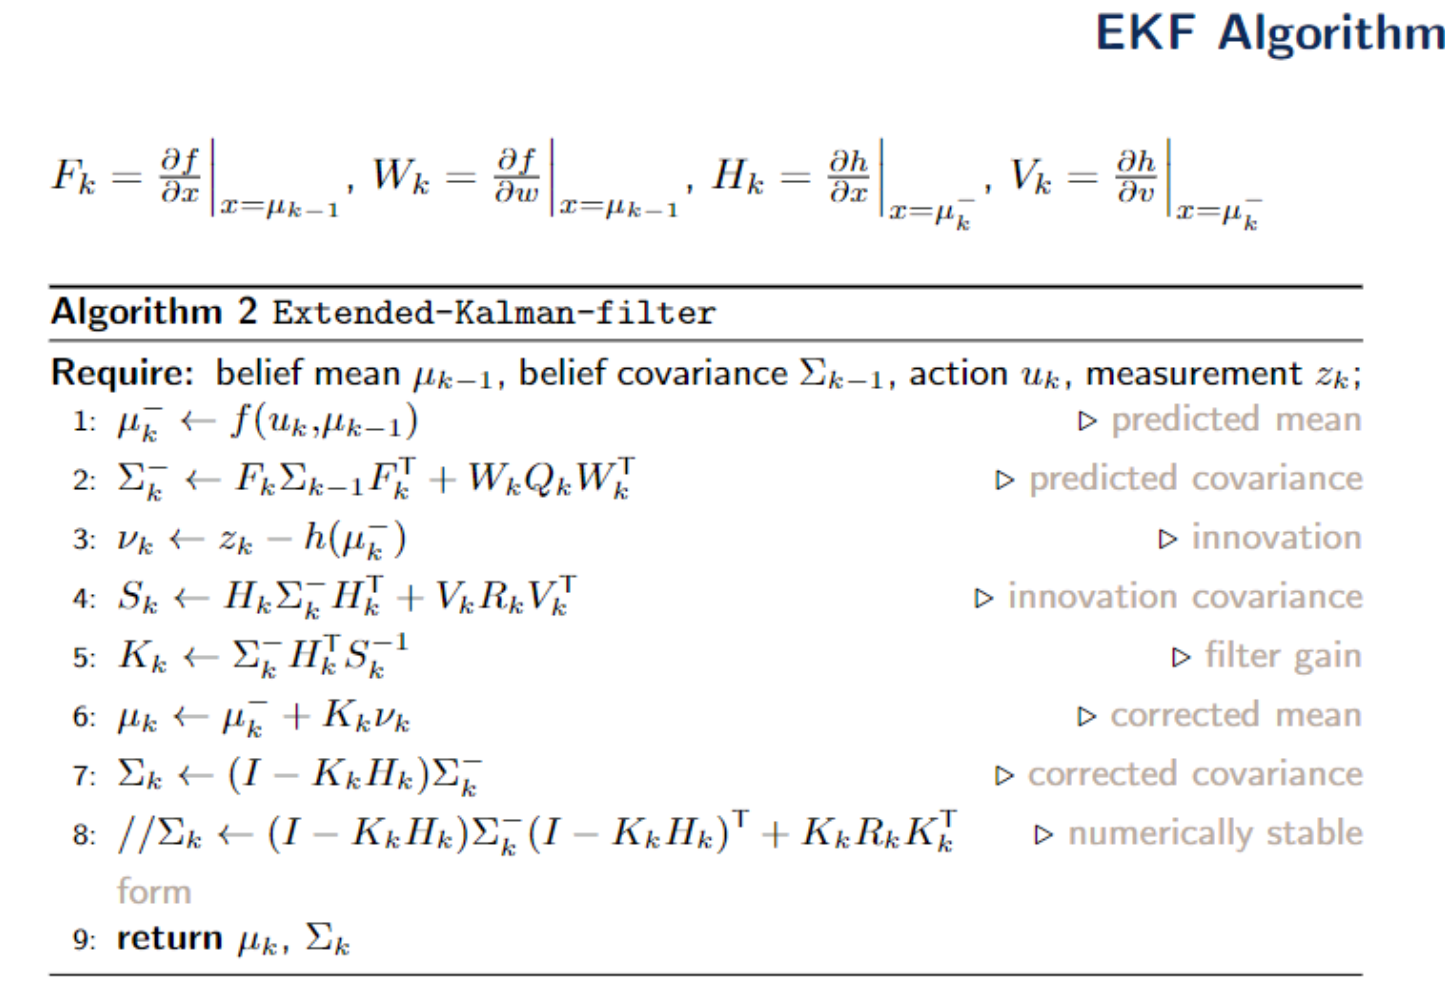

In [20]:
class extended_kalman_filter:

    def __init__(self, system, init, data):
        # EKF Construct an instance of this class
        #
        # Inputs:
        #   system: system and noise models
        #   init:   initial state mean and covariance
        self.A = system.A  # system matrix Jacobian
        self.B = system.B  # input matrix Jacobian
        self.f = system.f  # process model
        self.H1 = system.H1  # measurement model Jacobian
        self.H2 = system.H2  # measurement model Jacobian
        self.R1 = system.R1  # measurement noise covariance
        self.R2 = system.R2  # measurement noise covariance
        self.h1 = system.h1  # measurement model
        self.h2 = system.h2  # measurement model
        self.x1 = init.x1  # state vector actually the mean

        # accounting for vibrations
        self.Q1 = system.Q1  # input noise covariance
        # self.Q2 = system.Q2  # input noise covariance

        self.Sigma = init.Sigma  # state covariance


        ########################3
        # Modified for Part b
        self.R_stack = block_diag(system.R1, system.R2) #  prevents need to stack repeatedly


        ## Constants inputted
        self.C_1 = data.C_1
        self.C_2 = data.C_2
        self.Kf_1 = data.Kf_1
        self.Kf_2 = data.Kf_2
        self.Rot = data.R
        self.t = data.t


    def prediction_1(self):
        # EKF propagation (prediction) step
        # Taking care of the motion model in camera 1 here
        self.x_pred1 = self.f(self.x1)   # predicted state
        
        # Noise is addtive so W_k is idenity
        self.Sigma_pred1 = np.dot(np.dot(self.A, self.Sigma), self.A.T) + self.Q1  # predicted state covariance
        

    def correction1(self,z):
        self.z_hat1 = self.h1(self.Kf_1, self.x_pred1, self.C_1)  # predicted measurement
        H1 = self.H1(self.Kf_1, self.x_pred1)
        self.v1 = z - self.z_hat1
        self.S1 = np.dot(np.dot(H1, self.Sigma_pred1 ), H1.T) + self.R1 # innovation covariance

        # filter gain
        self.K1 = np.dot(np.dot(self.Sigma_pred1, H1.T), np.linalg.inv(self.S1))  # Kalman (filter) gain
        # correct the predicted state
        self.x1 = self.x_pred1 + np.dot(self.K1, self.v1)

        I = np.eye(np.shape(self.x1)[0])
        temp = I - np.dot(self.K1, H1)
        self.Sigma = np.dot(np.dot(temp, self.Sigma_pred1), temp.T) + np.dot(np.dot(self.K1, self.R1), self.K1.T)  # Joseph update form

    def correction2(self, z):
        self.z_hat2 = self.h2(self.Kf_2, self.x1, self.C_2)
        H2 = self.H2(self.Kf_2, self.x1, self.Rot, self.t) #Note that I am using the x1 as a state
        self.v2 = z - self.z_hat2
        self.S2 = np.dot(np.dot(H2, self.Sigma), H2.T) + self.R2  # innovation covariance

        # filter gain

        self.K2 = np.dot(np.dot(self.Sigma, H2.T), np.linalg.inv(self.S2))  # Kalman (filter) gain

        # correct the predicted state
        self.x1 = self.x1 + np.dot(self.K2, self.v2)
        I = np.eye(np.shape(self.x1)[0])
        temp = I - np.dot(self.K2, H2)
        self.Sigma = np.dot(np.dot(temp, self.Sigma), temp.T) + np.dot(np.dot(self.K2, self.R2),self.K2.T)  # Joseph update form


    def correction_batch(self, z_stack):
        """
        :param z_stack: inputted stacked measurments
        :return:
        """
        z_hat1 = self.h1(self.Kf_1, self.x1, self.C_1)
        z_hat2 = self.h2(self.Kf_2, self.x1, self.C_2)

        self.z_hat_stack = np.append(z_hat1, z_hat2, axis=0)

        self.v = z_stack - self.z_hat_stack # innovation

        H1 = self.H1(self.Kf_1, self.x1)
        H2 = self.H2(self.Kf_2, self.x1, self.Rot, self.t)
        H =  np.append(H1,H2, axis = 0) # stacked Jacobian

        self.S = np.dot(np.dot(H, self.Sigma_pred1), H.T) + self.R_stack

        self.K = np.dot(np.dot(self.Sigma_pred1, H.T), np.linalg.inv(self.S))

        self.x1 = self.x1 + np.dot(self.K, self.v)                     #note that x

        I = np.eye(np.shape(self.x1)[0])
        temp = I - np.dot(self.K, H)
        self.Sigma = np.dot(np.dot(temp, self.Sigma_pred1), temp.T) + np.dot(np.dot(self.K, self.R_stack), self.K.T)


### Fill the Jacobians, measurement and motion models for EKF

In [21]:
class myStruct:
    pass

def process_model(x):
    """
    Think this makes sense because we don't move at all
    :param x:
    :return:
    """
    f = np.array([x[0,0], x[1,0], x[2,0]], dtype=float)
    return f.reshape([3, 1])

def measurement_model_1(K_f, p, c_1):
    """
    :param K_f:  intrinisic Camera 1 Matrix
    :param p: point in frame 1
    :param c_1: optical center of image camera 1
    :return: process model camera 1
    """
    proj_func= np.array([p[0,0]/p[2,0], p[1,0]/p[2,0]], dtype=float).reshape((-1,1))
    return np.dot(K_f, proj_func) + c_1

def measurement_model_2(K_f, p, c_2):
    """
    :param K_f: intrinisic Camera 2 Matrix
    :param p: point in frame 1
    :param c_1:
    :return:
    """
    q = np.dot(R.T, p) - np.dot(R.T, t)
    proj_func= np.array([q[0,0]/q[2,0], q[1,0]/q[2,0]], dtype=float).reshape((-1,1))
    return np.dot(K_f, proj_func) + c_2

def measurment_Jacobain_1(K_f, p):
    """
    :param K_f: intrinisic Camera 1 Matrix
    :param p: point in frame 1
    :return: mesaurment jacobian
    """
    d_pi_dp_1 = np.array([[1./p[2,0], 0, -p[0,0]/(p[2,0]**2)],[0, 1/p[2,0], -p[1,0]/(p[2,0]**2)]], dtype=float)
    lin_H_1 = np.dot(K_f, d_pi_dp_1)
    return lin_H_1

def measurment_Jacobain_2(K_f, p, R,t):
    """
    :param K_f: intrinisic Camera 2 Matrix
    :param p: point in frame 1
    :param R: Rotation matrix from frame 1 to 2
    :param t: translation from frame 1 to 2
    :return: mesaurment jacobian
    """
    # Need to make sure inputs are correct
    q = np.dot(R.T, p) - np.dot(R.T, t)
    d_pi_dp_2 = np.array([[1/q[2,0], 0, -q[0,0]/(q[2,0]**2)],[0, 1/q[2,0] ,-q[1,0]/(q[2,0]**2)]], dtype=float)
    lin_H_2 = np.dot(np.dot(K_f, d_pi_dp_2), R.T)
    return lin_H_2



C_1 = np.loadtxt(open('data/C_1.csv'), delimiter=",").reshape(-1, 1)
C_2 = np.loadtxt(open('data/C_2.csv'), delimiter=",").reshape(-1, 1)
Kf_1 = np.loadtxt(open('data/Kf_1.csv'), delimiter=",")
Kf_2 = np.loadtxt(open('data/Kf_2.csv'), delimiter=",")
R = np.loadtxt(open('data/R.csv'), delimiter=",")
t = np.loadtxt(open('data/t.csv'), delimiter=",").reshape(-1, 1)
z_1 = np.loadtxt(open('data/z_1.csv'), delimiter=",")
z_2 = np.loadtxt(open('data/z_2.csv'), delimiter=",")

given_data = myStruct()
given_data.C_1 = C_1
given_data.C_2 =C_2
given_data.Kf_1 = Kf_1
given_data.Kf_2 = Kf_2
given_data.R = R
given_data.t = t

# initialize the state using the first measurement
init = myStruct()
init.x1 = np.zeros([3,1])
init.x1[0,0] = 0.12
init.x1[1,0] = 0.09
init.x1[2, 0] = 1.5
init.Sigma = np.eye(3) #Tune


# Build the system
sys = myStruct()
sys.A = np.eye(3)  # double check size
sys.B = []  # no input because the object is static
sys.f = process_model
sys.H1 = measurment_Jacobain_1 # 2 by3
sys.H2 = measurment_Jacobain_2 # # 2by 3
sys.R1 = np.cov(z_1, rowvar=False)  # double check 2by 2
sys.R2 = np.cov(z_2, rowvar=False)  # double check 2 by 2
sys.h1 = measurement_model_1
sys.h2 = measurement_model_2
sys.Q1 = np.array([[0.03, 0.02, 0.01],
                   [0.02, 0.04, 0.01],
                   [0.01, 0.01, 0.05]]).reshape((3, 3))  # vibrations

### EKF with sequential updates

Final x: 0.2808, y: 0.1905, z: 1.9666


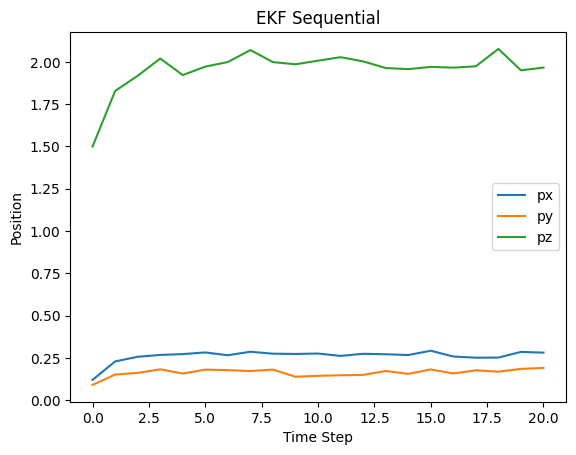

In [22]:
##################################################
ekf = extended_kalman_filter(sys, init, given_data)
x1_a = []
x1_a.append(init.x1)  # state
# main loop; iterate over the measurement

# started from 0 instead cuz picked random init
for i in range(0, np.shape(z_1)[0], 1):
    ekf.prediction_1()
    # Need to account for z_2 that wasn't initlized
    ekf.correction1(z_1[i, :].reshape([2, 1]))
    ekf.correction2(z_2[i,:].reshape([2,1]))
    x1_a.append(ekf.x1)

x1_a = np.array(x1_a).reshape((-1,3))
#################################################

# Final Label
print('Final x: %.4f, y: %.4f, z: %.4f' % (x1_a[-1,0], x1_a[-1,1], x1_a[-1,2]))

# plotting
fig = plt.figure()
plt.plot(x1_a[:, 0], label='px')
plt.plot(x1_a[:, 1], label='py')
plt.plot(x1_a[:, 2], label ='pz')
plt.xlabel(r'Time Step')
plt.ylabel(r'Position')
plt.legend()
plt.title('EKF Sequential')
plt.show()

### EKF with batch updates

Final x: 0.2808, y: 0.1905, z: 1.9669


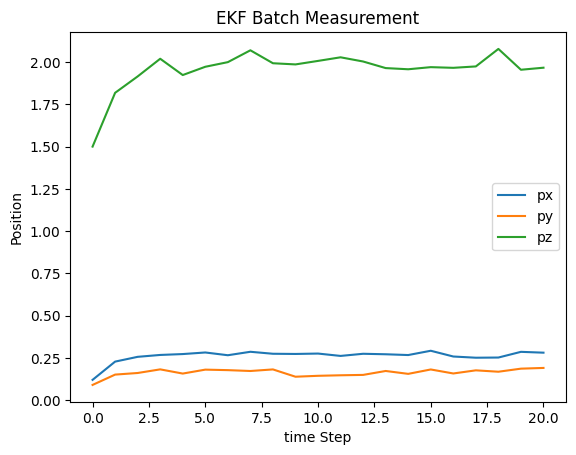

In [23]:
# ################################################
# Problem 1b
ekf_1b = extended_kalman_filter(sys, init, given_data)
x1_b = []
x1_b.append(init.x1)

# started from 0 instead cuz picked random init
for i in range(0, np.shape(z_1)[0],1):
    ekf_1b.prediction_1()
    z = np.append(z_1[i, :], z_2[i, :]).reshape((-1,1))
    ekf_1b.correction_batch(z)
    x1_b.append(ekf_1b.x1)

x1_b = np.array(x1_b).reshape((-1,3))


# Final Label
print('Final x: %.4f, y: %.4f, z: %.4f' % (x1_b[-1,0], x1_b[-1,1], x1_b[-1,2]))
# plotting
fig = plt.figure()
plt.plot(x1_b[:, 0], label='px')
plt.plot(x1_b[:, 1], label='py')
plt.plot(x1_b[:, 2], label ='pz')
plt.xlabel(r'time Step')
plt.ylabel(r'Position')
plt.legend()
plt.title('EKF Batch Measurement')
plt.show()


### PF implementation
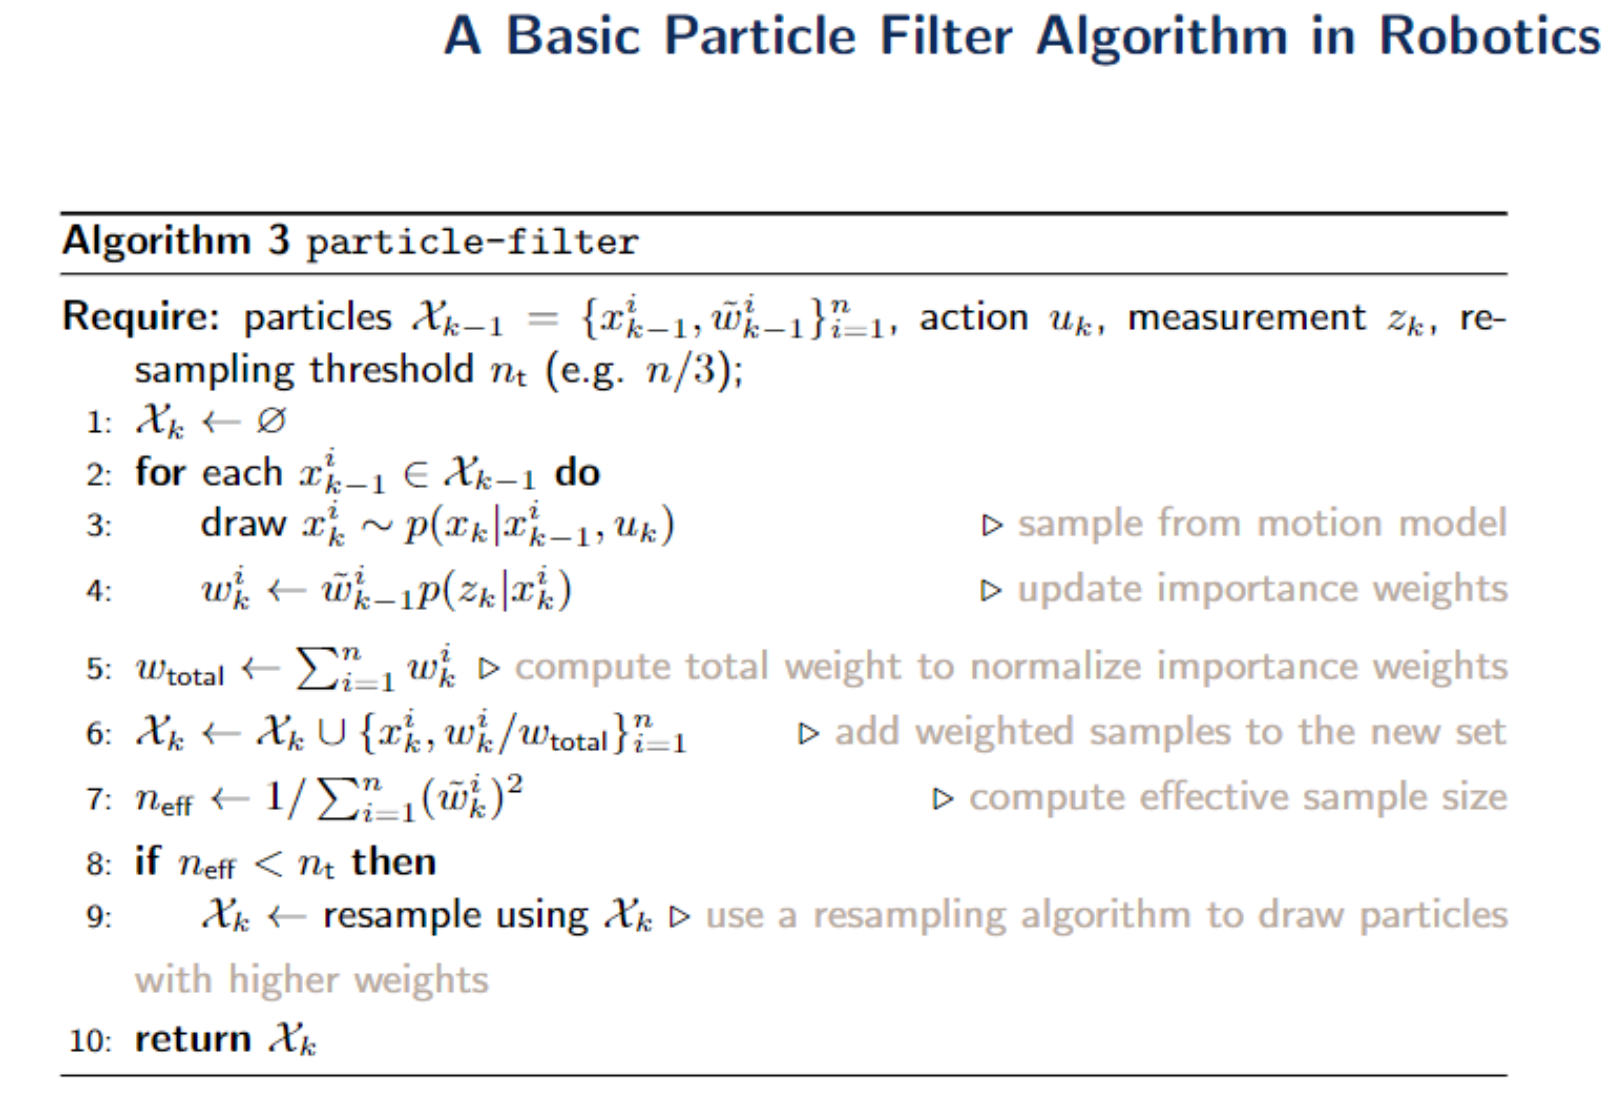

In [24]:
class myStruct():
    def __init__(self):
        self.x = []
        self.w = []

# Particle filter class for state estimation of a nonlinear system
# The implementation follows the Sample Importance Resampling (SIR)
# filter a.k.a bootstrap filter
class particle_filter:

    def __init__(self, system, init, data):
        # Particle filter construct an instance of this class
        #
        # Input:
        #   system: system and noise models
        #   init:   initialization parameters
        #   data:   constant terms for models

        # self.A = system.A  # system matrix        # don't need
        # self.B = system.B  # input matrix         # don't need
        self.f = system.f  # process model
        # self.H1 = system.H1  # measurement model Jacobian
        # self.H2 = system.H2  # measurement model Jacobian
        self.R1 = system.R1  # measurement noise covariance
        self.R2 = system.R2  # measurement noise covariance
        self.h1 = system.h1  # measurement model
        self.h2 = system.h2  # measurement model
        self.n = init.n  # number of particles
        self.x = init.x  # state vector

        # accounting for vibrations
        self.Q1 = system.Q1  # input noise covariance
        self.LQ = np.linalg.cholesky(self.Q1)
        # self.Q2 = system.Q2  # input noise covariance

        self.Sigma = init.Sigma  # state covariance


        ########################3
        # Modified for Part b
        self.R_stack = block_diag(system.R1, system.R2) #  prevents need to stack repeatedly


        ## Constants inputted
        self.C_1 = data.C_1
        self.C_2 = data.C_2
        self.Kf_1 = data.Kf_1
        self.Kf_2 = data.Kf_2
        self.Rot = data.R
        self.t = data.t

        # initialize particles
        self.p = myStruct() #particles

        wu = 1/self.n   # uniform weights

        L_init = np.linalg.cholesky(init.Sigma)
        for i in range(self.n):
            self.p.x.append(np.dot(L_init, randn(len(init.x), 1)) + init.x) #3 x 3  3 x 1 + 3x1 => 3x1
            self.p.w.append(wu)

        # I think rn this would change particles to row vectors
        self.p.x = np.array(self.p.x).reshape(-1, len(init.x))  # nx3
        self.p.w = np.array(self.p.w).reshape(-1, 1)            # nx1
        #######################################################

    def sample_motion(self):
        # A simple random walk motion model
        for i in range(self.n):
            # sample noise
            w = np.dot(self.LQ, randn(3, 1)) # should be 3 x 1
            # w = np.dot(self.LQ, np.array([[0.5], [0.01]]))
            # propagate the particle
            self.p.x[i, :] = self.f(self.p.x[i, :], w).reshape(-1) # inputs vector into a row

    def importance_measurement_1(self, z):
        # compare important weight for each particle based on the obtain range and bearing measurements
        #
        # Inputs:
        #   z: measurement  2x1
        w = np.zeros([self.n, 1])  # importance weights nx1
        for i in range(self.n):
            # compute innovation statistics
            # We know here z[1] is an angle
            v = z - self.h1(self.Kf_1, self.p.x[i, :], self.C_1)
            w[i] = multivariate_normal.pdf(v.reshape(-1), np.array([0, 0]), self.R1)

        # update and normalize weights
        self.p.w = np.multiply(self.p.w, w)  # since we used motion model to sample nx1 nx1 => nx1
        self.p.w = self.p.w / np.sum(self.p.w)
        # compute effective number of particles
        self.Neff = 1 / np.sum(np.power(self.p.w, 2))  # effective number of particles

    def importance_measurement_2(self, z):
        # compare important weight for each particle based on the obtain range and bearing measurements
        #
        # Inputs:
        #   z: measurement  2x1
        w = np.zeros([self.n, 1])  # importance weights nx1
        for i in range(self.n):
            # compute innovation statistics
            # We know here z[1] is an angle
            v = z - self.h2(self.Kf_2, self.p.x[i, :], self.C_2)
            w[i] = multivariate_normal.pdf(v.reshape(-1), np.array([0, 0]), self.R2)

        # update and normalize weights
        self.p.w = np.multiply(self.p.w, w)  # since we used motion model to sample nx1 nx1 => nx1
        self.p.w = self.p.w / np.sum(self.p.w) # This looks like line 6 of particle-filter code
        # compute effective number of particles
        self.Neff = 1 / np.sum(np.power(self.p.w, 2))  # effective number of particles

    def importance_mesurement_batch(self, z):
        """
        :param z: measurment vector 4x1 stacked z_1 then z_2
        """
        w = np.zeros([self.n, 1])  # importance weights nx1
        for i in range(self.n):
            # compute innovation statistics
            # We know here z[1] is an angle
            z_hat1 = self.h1(self.Kf_1, self.p.x[i, :], self.C_1)
            z_hat2 = self.h2(self.Kf_2, self.p.x[i, :], self.C_2)

            self.z_hat_stack = np.append(z_hat1, z_hat2, axis=0)

            v = z - self.z_hat_stack
            w[i] = multivariate_normal.pdf(v.reshape(-1), np.array([0, 0, 0, 0]), self.R_stack)

        # update and normalize weights
        self.p.w = np.multiply(self.p.w, w)  # since we used motion model to sample nx1 nx1 => nx1
        self.p.w = self.p.w / np.sum(self.p.w)  # This looks like line 6 of particle-filter code
        # compute effective number of particles
        self.Neff = 1 / np.sum(np.power(self.p.w, 2))  # effective number of particles

    def resampling(self):
        # low variance resampling
        W = np.cumsum(self.p.w)
        r = rand(1) / self.n
        # r = 0.5 / self.n
        j = 1
        for i in range(self.n):
            u = r + (i - 1) / self.n
            while u > W[j]:
                j = j + 1
            self.p.x[i, :] = self.p.x[j, :]
            self.p.w[i] = 1 / self.n


### Fill the measurement model and motion model for PF

In [25]:
def process_model(x, w):
    """
    Think this makes sense because we don't move at all
    :param x: actually point with respect to frame 1
    :param w: noise vector sampled as part of the motion model (the vibes )
    :return:
    """
    f = np.array([x[0], x[1], x[2]], dtype=float).reshape([3,1]) + w
    return f.reshape([3, 1])

def measurement_model_1(K_f, p, c_1):
    """
    :param K_f:  intrinisic Camera 1 Matrix
    :param p: point in frame 1
    :param c_1: optical center of image camera 1
    :return: process model camera 1
    """
    proj_func= np.array([p[0]/p[2], p[1]/p[2]], dtype=float).reshape((-1,1))
    return np.dot(K_f, proj_func) + c_1

def measurement_model_2(K_f, p, c_2):
    """
    :param K_f: intrinisic Camera 2 Matrix
    :param p: point in frame 1
    :param c_1:
    :return:
    """
    p = p.reshape([3,1])
    q = np.dot(R.T, p) - np.dot(R.T, t)
    proj_func= np.array([q[0]/q[2], q[1]/q[2]], dtype=float).reshape((-1,1))
    return np.dot(K_f, proj_func) + c_2



C_1 = np.loadtxt(open('data/C_1.csv'), delimiter=",").reshape(-1, 1)
C_2 = np.loadtxt(open('data/C_2.csv'), delimiter=",").reshape(-1, 1)
Kf_1 = np.loadtxt(open('data/Kf_1.csv'), delimiter=",")
Kf_2 = np.loadtxt(open('data/Kf_2.csv'), delimiter=",")
R = np.loadtxt(open('data/R.csv'), delimiter=",")
t = np.loadtxt(open('data/t.csv'), delimiter=",").reshape(-1, 1)
z_1 = np.loadtxt(open('data/z_1.csv'), delimiter=",")
z_2 = np.loadtxt(open('data/z_2.csv'), delimiter=",")

given_data = myStruct()
given_data.C_1 = C_1
given_data.C_2 =C_2
given_data.Kf_1 = Kf_1
given_data.Kf_2 = Kf_2
given_data.R = R
given_data.t = t


# initialize the state using the first measurement
init = myStruct()
init.x = np.zeros([3,1])
init.x[0, 0] = 0.12
init.x[1, 0] = 0.09
init.x[2, 0] = 1.5
init.n = 1000
init.Sigma = np.eye(3) #Tune


# Build the system
sys = myStruct()
sys.f = process_model
sys.R1 = np.cov(z_1, rowvar=False)  # double check 2by 2
sys.R2 = np.cov(z_2, rowvar=False)  # double check 2 by 2
sys.h1 = measurement_model_1
sys.h2 = measurement_model_2
sys.Q1 = np.array([[0.03,0.02,0.01],
                   [0.02,0.04, 0.01],
                   [0.01,0.01, 0.05]]).reshape((3,3)) # vibrations


filter = particle_filter(sys, init, given_data)
x = np.empty([3, np.shape(z_1)[0]+1]) # used since picked a random init
x[:, 0] = [init.x[0, 0], init.x[1, 0], init.x[2, 0]]  # don't need since picked random point


### PF with sequential updates

Final x: 0.2827, y: 0.1832, z: 1.9813


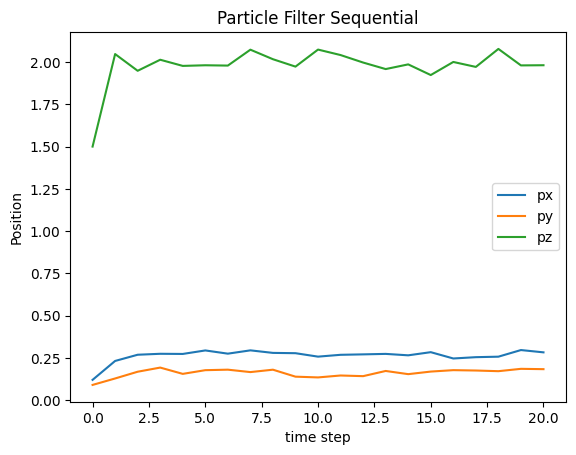

In [26]:


green = np.array([0.2980, .6, 0])

# started from 0 instead cuz picked random init
for i in range(0, np.shape(z_1)[0], 1):
    filter.sample_motion()

    #####################################################
    # First measurement
    filter.importance_measurement_1(z_1[i,:].reshape([2,1]))
    if filter.Neff < filter.n/100:   # Note sampling threshold is hidden in there
        filter.resampling() # does this work correctly terms of shapes
    ############################################################################

    ##########################################################################3
    # measurement 2
    filter.importance_measurement_2(z_2[i,:].reshape([2,1]))
    if filter.Neff < filter.n/5:  # Note sampling threshold is hidden in there
        filter.resampling()  # does this work correctly terms of shapes
    wtot = np.sum(filter.p.w)

    if wtot > 0:
        a = filter.p.x
        b = filter.p.w
        x[0, i+1] = np.sum(filter.p.x[:, 0] * filter.p.w.reshape(-1)) / wtot
        x[1, i+1] = np.sum(filter.p.x[:, 1] * filter.p.w.reshape(-1)) / wtot
        x[2, i+1] = np.sum(filter.p.x[:, 2] * filter.p.w.reshape(-1)) / wtot
    else:
        print('\033[91mWarning: Total weight is zero or nan!\033[0m')
        x[:, i+1] = [np.nan, np.nan, np.nan]

    # End of measurment 2
    ########################################################################


# Final Label
print('Final x: %.4f, y: %.4f, z: %.4f' % (x[0,-1], x[1,-1], x[2,-1]))

fig = plt.figure()
plt.plot(x[0, :], label='px')
plt.plot(x[1, :], label='py')
plt.plot(x[2, :], label='pz')
plt.title('Particle Filter Sequential')
plt.xlabel(r'time step')
plt.ylabel(r'Position')
plt.legend()
plt.show()


### PF with batch updates

Final x: 0.2752, y: 0.2055, z: 1.9811


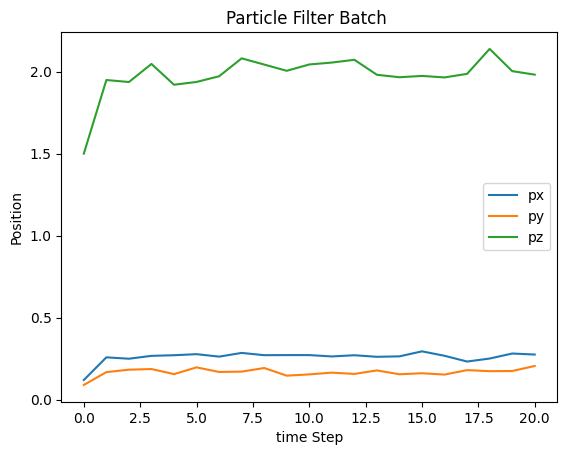

here


In [27]:
green = np.array([0.2980, .6, 0])

# started from 0 instead cuz picked random init
for i in range(0, np.shape(z_1)[0], 1):
    filter.sample_motion()

    #####################################################
    # First measurement
    z = np.append(z_1[i, :], z_2[i, :]).reshape((-1,1))

    filter.importance_mesurement_batch(z)
    if filter.Neff < filter.n/5:   # Note sampling threshold is hidden in there
        filter.resampling() # does this work correctly terms of shapes
    wtot = np.sum(filter.p.w)

    if wtot  > 0:
        # a = filter.p.x
        # b = filter.p.w
        x[0, i+1] = np.sum(filter.p.x[: , 0] * filter.p.w.reshape(-1)) / wtot
        x[1 ,i+1] = np.sum(filter.p.x[: , 1] * filter.p.w.reshape(-1))/ wtot
        x[2, i+1] = np.sum(filter.p.x[:, 2] * filter.p.w.reshape(-1)) / wtot
    else:
        print('\033[91mWarning: Total weight is zero or nan!\033[0m')
        x[:, i+1] = [np.nan, np.nan, np.nan]
    ############################################################################


# Final Label
print('Final x: %.4f, y: %.4f, z: %.4f' % (x[0,-1], x[1,-1], x[2,-1]))

# quit()
fig = plt.figure()
# axis = np.linspace()
plt.plot(x[0,:], label='px' )
plt.plot(x[1,:], label='py')
plt.plot(x[2,:], label ='pz')
plt.title('Particle Filter Batch ')
plt.xlabel(r'time Step')
plt.ylabel(r'Position')
plt.legend()
plt.show()



print('here')